# Analisis exploratorio: Las personas y el terremoto

Trataremos de entender que le sucedio a las personas, teniendo en cuenta que es una dataset de edificios.

## Importo librerias y cargo los datos

In [2]:
# importacion general de librerias y de visualizacion (matplotlib y seaborn)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random as rd
%matplotlib inline

plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib
#plt.rcParams['figure.figsize'] = (20, 10)

sns.set(style="whitegrid") # seteando tipo de grid en seaborn

pd.options.display.float_format = '{:20,.2f}'.format # suprimimos la notacion cientifica en los outputs

import warnings
warnings.filterwarnings('ignore')

In [3]:
#Levantar los datos de cada edificio/casa
df = pd.read_csv('datos/train_values.csv',nrows=0)
columnas = df.columns.to_list()
datatypes = {
    **{columnas[0]:np.int32}\
    , **{column:np.int16 for column in columnas[1:8] + columnas[27:28]}\
    , **{column:'category' for column in columnas[8:15] + columnas[26:27]}\
    , **{column:np.bool for column in columnas[15:26] + columnas[28:39]}
}
edificios = pd.read_csv('datos/train_values.csv',dtype=datatypes)

In [4]:
#Datos de el daño por edificio
daños = pd.read_csv('datos/train_labels.csv',dtype={'building_id':np.int32,'damage_grade':'category'})

##  Daños y localizaciones
Veamos que zonas son las mas afectadas por el terremoto en terminos cuantitativos en las regiones más grandes

In [5]:
edificios_geo = edificios.loc[:,['building_id','geo_level_1_id']]
edificios_geo_daños = pd.merge(edificios_geo,daños,on='building_id',how='inner').groupby(['geo_level_1_id','damage_grade']).count().unstack()
edificios_geo_daños.head(3)

building_id           
damage_grade             1     2    3
geo_level_1_id                       
0                      337  3075  599
1                      411  1985  305
2                       85   610  236

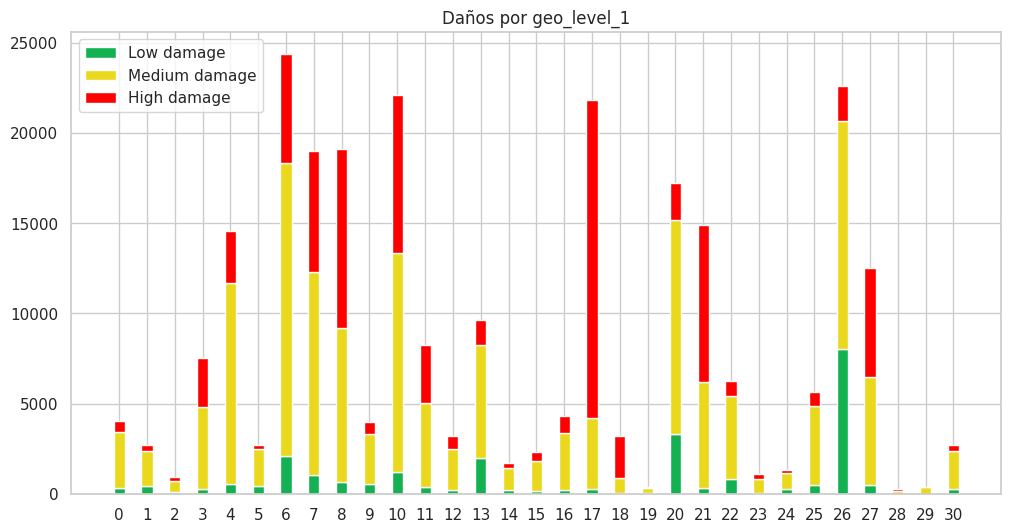

In [6]:
labels = edificios_geo_daños.index.to_list()
low_affected = np.array(edificios_geo_daños[('building_id','1')].to_list())
medium_affected = np.array(edificios_geo_daños[('building_id','2')].to_list())
high_affected = np.array(edificios_geo_daños[('building_id','3')].to_list())

width = 0.4
fig, ax = plt.subplots(figsize=(12,6))

ax.bar(labels, low_affected, width, label='Low damage',color='#13b151')
ax.bar(labels, medium_affected, width, bottom=low_affected,label='Medium damage', color='#ead81c')
ax.bar(labels, high_affected, width, bottom=low_affected+medium_affected,label='High damage', color='red')

ax.set_title('Daños por geo_level_1')
ax.legend()
plt.xticks(labels)
plt.show()

La región que más recibió daños graves es la 17 por amplia diferencia. Le siguen de la 6 a la 10 y la 21.

Ordenemos por daño recibido a ver si nuestras afirmaciones son correctas

In [7]:
edificios_geo_daños_sorted = edificios_geo_daños.sort_values(by=('building_id','3'),ascending=False)
edificios_geo_daños_sorted.head(3)

building_id              
damage_grade             1      2      3
geo_level_1_id                          
17                     285   3913  17615
8                      654   8513   9913
10                    1211  12107   8761

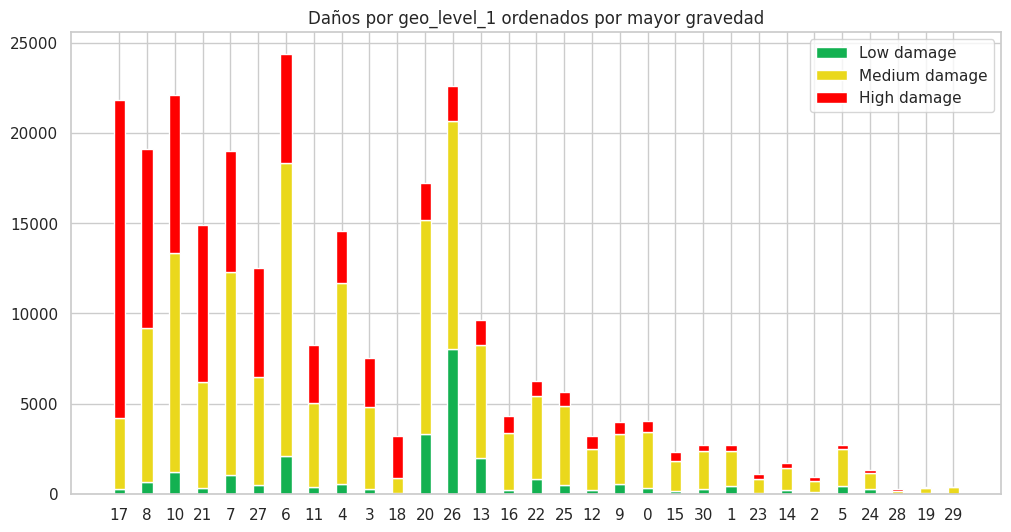

In [8]:
labels = edificios_geo_daños_sorted.index.to_list()
labels = [str(region) for region in labels] #para que no ordene los index, convierto los labels en string
low_affected = np.array(edificios_geo_daños_sorted[('building_id','1')].to_list())
medium_affected = np.array(edificios_geo_daños_sorted[('building_id','2')].to_list())
high_affected = np.array(edificios_geo_daños_sorted[('building_id','3')].to_list())

width = 0.4
fig, ax = plt.subplots(figsize=(12,6))

ax.bar(labels, low_affected, width, label='Low damage',color='#13b151')
ax.bar(labels, medium_affected, width, bottom=low_affected,label='Medium damage', color='#ead81c')
ax.bar(labels, high_affected, width, bottom=low_affected+medium_affected,label='High damage', color='red')

ax.set_title('Daños por geo_level_1 ordenados por mayor gravedad')
ax.legend()
plt.xticks(labels)
plt.show()

Las preguntas que nos podemos hacer son las siguientes:
* ¿Aquellas regiones que más cantidad de daños graves tuvieron, están más cerca del epicentro?
* ¿Puede que esto sea fruto de que simplemente haya más cantidad de edificios en esa zona?

Estas preguntas están relacionadas, veamos que pasa si ordenamos de manera porcentual respecto de la cantidad de edificios de la region

In [9]:
edificios_geo_daños_perc = edificios_geo_daños.div(edificios_geo_daños.sum(axis=1), axis=0).sort_values(by=('building_id','3'),ascending=False)
edificios_geo_daños_perc.head()

building_id                                          
damage_grade                      1                    2                    3
geo_level_1_id                                                               
17                             0.01                 0.18                 0.81
18                             0.02                 0.25                 0.73
21                             0.02                 0.39                 0.58
8                              0.03                 0.45                 0.52
27                             0.04                 0.48                 0.48

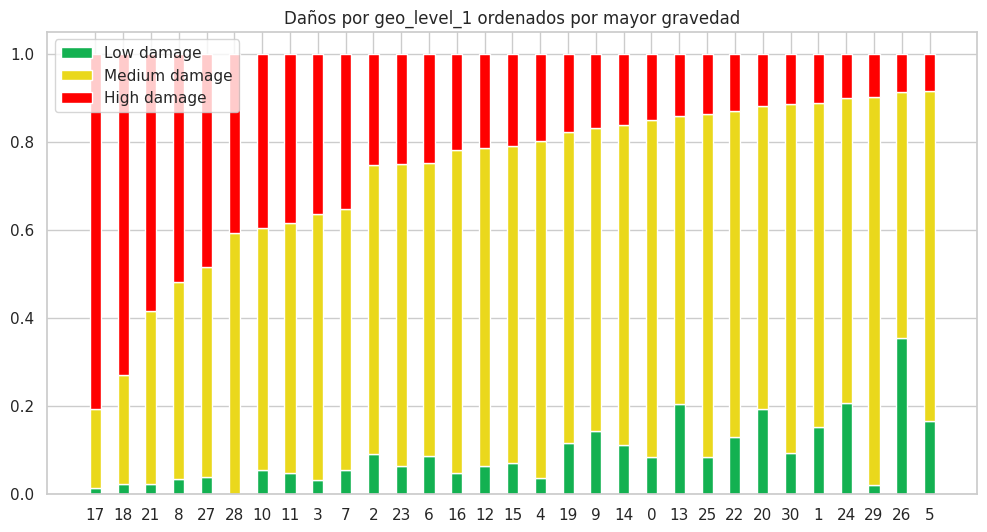

In [10]:
labels = edificios_geo_daños_perc.index.to_list()
labels = [str(region) for region in labels] #para que no ordene los index, convierto los labels en string
low_affected = np.array(edificios_geo_daños_perc[('building_id','1')].to_list())
medium_affected = np.array(edificios_geo_daños_perc[('building_id','2')].to_list())
high_affected = np.array(edificios_geo_daños_perc[('building_id','3')].to_list())

width = 0.4
fig, ax = plt.subplots(figsize=(12,6))

ax.bar(labels, low_affected, width, label='Low damage',color='#13b151')
ax.bar(labels, medium_affected, width, bottom=low_affected,label='Medium damage', color='#ead81c')
ax.bar(labels, high_affected, width, bottom=low_affected+medium_affected,label='High damage', color='red')

ax.set_title('Daños por geo_level_1 ordenados por mayor gravedad')
ax.legend()
plt.xticks(labels)
plt.show()

Aca se puede ver que por ejemplo la región 18 fue bastante afectada respecto de la cantidad de edificios en la región. Esto no se veía en el grafico anterior. Lo tendremos en cuenta para más adelante

Ya sabemos en que zonas se encuentran las mas afectadas en terminos de cantidad de edificios. Veamos que podemos averiguar de estas zonas

## Estructuras en las zonas más afectadas

Tomemos las 10 regiones mas dañadas gravemente segun la cantidad de edificios. (Pues ya hicimos las estructuras por zona)

In [11]:
top_10_hd_ids = edificios_geo_daños_sorted.index.to_list()[:11]
top_10_hd_ids

[17, 8, 10, 21, 7, 27, 6, 11, 4, 3, 18]

In [12]:
superstructures = edificios.loc[:,['geo_level_1_id']+columnas[15:26]] # building_id + secondary_use
superstructures_top10_hd = superstructures.groupby('geo_level_1_id').sum()
superstructures_top10_hd = superstructures_top10_hd.loc[superstructures_top10_hd.index.isin(top_10_hd_ids),:]
#superstructures_top10_hd_tot = superstructures_top10_hd.sum().to_frame().rename(columns={0:'total'})
superstructures_top10_hd = superstructures_top10_hd
superstructures_top10_hd

,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other
geo_level_1_id,,,,,,,,,,,
3,4457,1470,55,61,3950,870,1052,388,345,122,179
4,69,14259,518,131,13,63,2522,1469,452,44,197
6,3680,18239,85,113,1725,1673,2546,395,984,848,118
7,381,15907,1160,479,1012,784,4622,411,843,235,198
8,771,17290,491,259,286,558,3201,1015,701,255,412
10,738,19391,938,413,199,1064,6242,420,782,376,190
11,2778,3502,388,105,3477,899,2263,1037,311,132,182
17,618,20257,1383,341,231,757,3675,1046,555,157,44
18,13,2260,965,114,6,70,1172,151,348,40,9


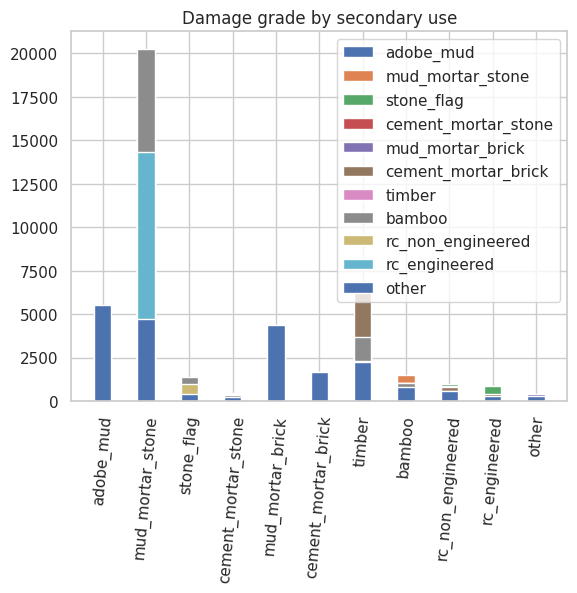

In [24]:
labels = columnas[15:26]
labels = [superstructure.split("superstructure_")[-1] for superstructure in labels]
superstructures_all_cants = superstructures_top10_hd.values.tolist()
width = 0.4
fig, ax = plt.subplots()

for i in range(len(labels)):
    ant = None
    superstructures_cant = np.array(superstructures_all_cants[i])
    ax.bar(labels, superstructures_cant, width,bottom= ant, label=labels[i])
    if ant is None:
        ant = superstructures_cant
    else: ant+= superstructures_cant
#low_affected,medium_affected,high_affected = np.array(damage_sec_use_perc.values.tolist())
# ax.bar(labels, low_affected, width, label='Low damage',color='#13b151')
# ax.bar(labels, medium_affected, width, bottom=low_affected,label='Medium damage', color='#ead81c')
# ax.bar(labels, high_affected, width, bottom=low_affected+medium_affected,label='High damage', color='red')


ax.set_title('Damage grade by secondary use')
ax.legend()
plt.xticks(rotation=85)
plt.show()